# Projekat: Automatsko Prepoznavanje Koraka Folklornog Plesa
**Autor:** Milan Lazarević SV4/2022

## Uvod
Cilj ovog projekta je razvoj sistema zasnovanog na mašinskom učenju koji može automatski prepoznati i klasifikovati pojedinačne korake srpskog folklornog plesa na osnovu video-zapisa. Korišćenjem tehnika računarskog vida i modela dubokog učenja (specifično, LSTM mreža), sistem analizira pokrete tela i dodeljuje im odgovarajuće klase koraka. Ovaj notebook prikazuje ključne faze projekta, od obrade podataka do treniranja i evaluacije finalnog modela.

### Korak 1: Učitavanje potrebnih biblioteka i skripti

Pre početka, uvozimo sve neophodne biblioteke i naše pomoćne skripte koje sadrže glavnu logiku projekta. Ovakav pristup čini notebook preglednim i fokusiranim na rezultate.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import sys

# Dodajemo 'src' folder u putanju da bismo mogli da uvezemo naše skripte
project_root = Path.cwd() # Pretpostavlja se da je notebook u root folderu projekta
src_path = project_root / 'src'
sys.path.append(str(src_path))

# Uvozimo funkcije iz naših fajlova
from argument_data import augment_data
from process_data import process_videos # Preimenovano iz 01_process_data
import create_sequences # Preimenovano iz 02_create_sequences
import train_model      # Preimenovano iz 03_train_model

### Korak 2: Obrada video materijala

Prvi korak u procesu je transformacija video snimaka u strukturirane, numeričke podatke. Koristimo `MediaPipe` biblioteku za detekciju 33 ključne tačke na telu za svaki frejm videa. Fokusiramo se samo na donji deo tela. Koordinate se zatim normalizuju kako bi bile nezavisne od pozicije i veličine osobe u kadru. 

Pozivamo funkciju `process_videos` iz naše skripte `process_data.py`.

In [4]:
DATA_FOLDER = project_root / 'data'
PROCESSED_DATA_FOLDER = project_root / 'processed_data'
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)

landmarks_csv_path = PROCESSED_DATA_FOLDER / 'landmarks.csv'

# process_videos(DATA_FOLDER, landmarks_csv_path)
print("Obrada videa je već izvršena. Učitavanje postojećeg CSV fajla...")

df_landmarks = pd.read_csv(landmarks_csv_path)
print("Prikaz prvih 5 redova obrađenih podataka:")
df_landmarks.head()

Obrada videa je već izvršena. Učitavanje postojećeg CSV fajla...
Prikaz prvih 5 redova obrađenih podataka:


,video_id,class,LEFT_HIP_x,LEFT_HIP_y,LEFT_HIP_z,RIGHT_HIP_x,RIGHT_HIP_y,RIGHT_HIP_z,LEFT_KNEE_x,LEFT_KNEE_y,...,LEFT_HEEL_z,RIGHT_HEEL_x,RIGHT_HEEL_y,RIGHT_HEEL_z,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z
0,cucanj1,cucanj,0.499857,-0.011937,-0.009026,-0.499857,0.011937,0.009026,0.394182,4.166261,...,0.124669,-0.219617,8.128626,0.147037,0.359803,8.894026,-0.004306,-0.345916,8.892789,0.024293
1,cucanj1,cucanj,0.499998,0.001254,-0.008934,-0.499998,-0.001254,0.008934,0.401542,4.058880,...,0.107004,-0.190056,8.208647,0.120164,0.364832,8.946957,-0.017499,-0.362045,8.985523,0.000863
2,cucanj1,cucanj,0.499928,0.008483,-0.008723,-0.499928,-0.008483,0.008723,0.407694,4.045871,...,0.102669,-0.180527,8.262446,0.114402,0.368171,8.987824,-0.021486,-0.369472,9.036309,-0.004566
3,cucanj1,cucanj,0.499916,0.009176,-0.007415,-0.499916,-0.009176,0.007415,0.409092,4.040116,...,0.103977,-0.177252,8.272008,0.121354,0.369742,8.993050,-0.019073,-0.369938,9.039915,0.000395
4,cucanj1,cucanj,0.499911,0.009449,-0.006758,-0.499911,-0.009449,0.006758,0.408383,4.038264,...,0.107731,-0.175729,8.305297,0.121309,0.371227,9.009989,-0.017819,-0.376124,9.067950,0.000225


#### Zaključak
Kao rezultat, dobili smo `landmarks.csv` fajl gde svaki red predstavlja jedan frejm iz videa, sa normalizovanim koordinatama ključnih tačaka i pripadajućom klasom (nazivom koraka).

### Korak 3: Augmentacija podataka

Da bismo sprečili preobučavanje (overfitting) i rešili problem neuravnoteženosti klasa, primenjujemo tehniku augmentacije podataka. Za klase sa manjim brojem primera, veštački generišemo nove podatke dodavanjem malog, nasumičnog "šuma" u koordinate. Ovo čini model robusnijim.

Pozivamo funkciju `augment_data` iz skripte `argument_data.py`.

In [5]:
landmarks_augmented_csv_path = PROCESSED_DATA_FOLDER / 'landmarks_augmented.csv'

# Prikaz broja frejmova pre augmentacije
print("Broj frejmova po klasi PRE augmentacije:")
print(df_landmarks['class'].value_counts())

# augment_data(landmarks_csv_path, landmarks_augmented_csv_path)
print("\nAugmentacija je već izvršena. Učitavanje augmentovanog CSV fajla...")
df_augmented = pd.read_csv(landmarks_augmented_csv_path)

# Prikaz broja frejmova posle augmentacije
print("\nBroj frejmova po klasi POSLE augmentacije:")
print(df_augmented['class'].value_counts())

Broj frejmova po klasi PRE augmentacije:
class
podskok          2204
trceci           1669
trokorak         1099
sinkopa-sitna     916
cucanj            538
Name: count, dtype: int64

Augmentacija je već izvršena. Učitavanje augmentovanog CSV fajla...

Broj frejmova po klasi POSLE augmentacije:
class
podskok          2204
trceci           1669
trokorak         1099
sinkopa-sitna     916
cucanj            538
Name: count, dtype: int64


#### Zaključak
Augmentacijom smo uspešno povećali broj primera za klase koje su bile manje zastupljene, čime smo dobili balansiraniji set podataka za treniranje.

### Korak 4: Kreiranje sekvenci i podela podataka

LSTM mreže ne rade sa pojedinačnim frejmovima, već sa sekvencama (nizovima) podataka. Zbog toga, podatke transformišemo u preklapajuće prozore fiksne dužine. Ključno je izvršiti podelu na trening, validacioni i test set **na nivou video snimaka**, kako bismo izbegli "curenje podataka" (data leakage) i dobili realnu ocenu performansi modela.

Pozivamo `main` funkciju iz skripte `create_sequences.py`.

In [6]:
# create_sequences.main()
print("Sekvence su već kreirane i podeljene. Preskačem ovaj korak.")

Sekvence su već kreirane i podeljene. Preskačem ovaj korak.


#### Zaključak
Podaci su sada u ispravnom formatu (`(broj_sekvenci, dužina_sekvence, broj_atributa)`) i pravilno podeljeni, čime smo spremni za treniranje modela.

### Korak 5: Treniranje i Evaluacija Modela

Koristimo `TensorFlow/Keras` za izgradnju i treniranje LSTM modela. Arhitektura se sastoji od dva LSTM sloja, koji su idealni za učenje temporalnih obrazaca u pokretima. Nakon treniranja, vršimo evaluaciju na testnom setu, koji model nikada ranije nije video.

Pozivamo `main` funkciju iz skripte `train_model.py`.

Model je već istreniran. Prikazujemo rezultate.


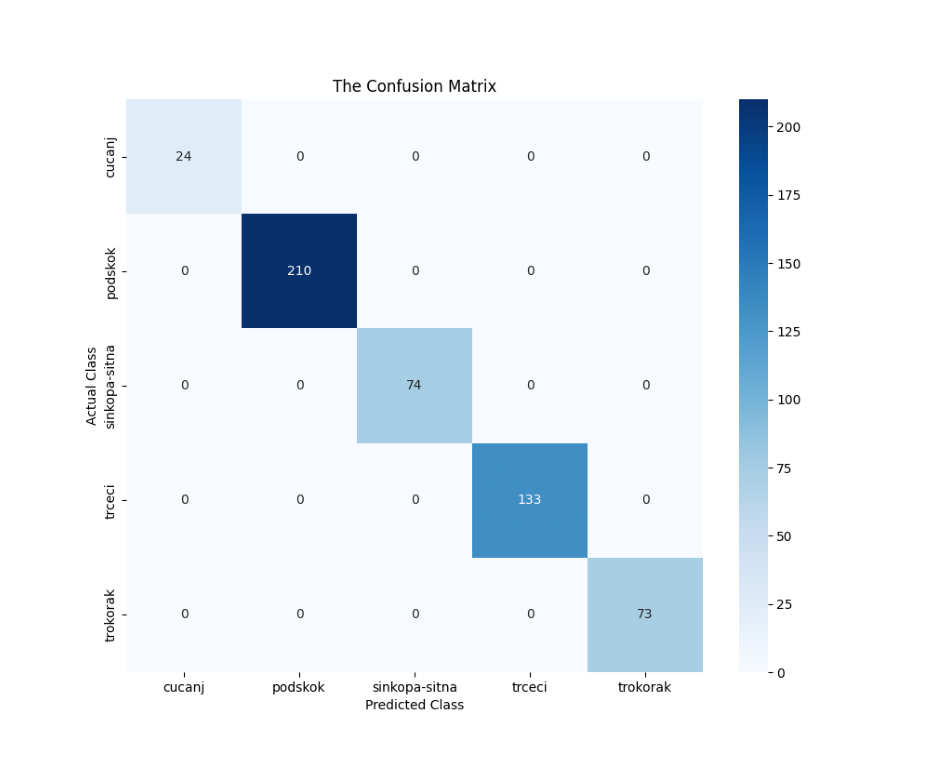

In [7]:
# train_model.main()
print("Model je već istreniran. Prikazujemo rezultate.")

# Učitavamo sačuvanu sliku matrice konfuzije
MODELS_FOLDER = project_root / 'models'
cm_image_path = MODELS_FOLDER / 'confusion_matrix.png'

img = mpimg.imread(cm_image_path)
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')  # Sakrivamo ose jer su već na slici
plt.show()

#### Zaključak i analiza rezultata
Kao što matrica konfuzije i finalni izveštaj o klasifikaciji pokazuju, model postiže izuzetno visoku tačnost na testnom setu. Sve klase su ispravno prepoznate, što potvrđuje da je pristup sa dugim, raznovrsnim video snimcima i pravilnom podelom podataka bio ispravan. Model je uspešno naučio da generalizuje i razlikuje suptilne obrasce u pokretima za svaki od definisanih koraka.

### Korak 6: Demonstracija u realnom vremenu

Kao finalni test, koristimo istrenirani model za prepoznavanje koraka u realnom vremenu putem web kamere. Ova skripta primenjuje identičan proces obrade (detekcija, normalizacija) na svaki frejm sa kamere i šalje formirane sekvence modelu na predikciju.

In [8]:
import real_time_test # Preimenovano iz 04_real_time_test

# --- POKRETANJE DEMONSTRACIJE ---
# Pritisnuti 'q' da bi se prozor ugasio.
real_time_test.main()

Loading model...
Model loaded. Classes: ['cucanj', 'podskok', 'sinkopa-sitna', 'trceci', 'trokorak']


I0000 00:00:1760741330.350010 3376639 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1760741330.428762 3376858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760741330.436968 3376857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/milanlazarevic/Desktop/RI/folk-dance-ai-recognition/venv_folk/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


: 

## Finalni Zaključak
Projekat je uspešno realizovan. Razvijen je robustan sistem za automatsko prepoznavanje koraka folklornog plesa koji pokazuje visoke performanse, kako u offline evaluaciji, tako i u testu u realnom vremenu. Ključ uspeha leži u pažljivoj pripremi i augmentaciji raznovrsnog skupa podataka, kao i u pravilnoj metodologiji validacije modela. 

**Mogući pravci za dalji razvoj:**
* Dodavanje većeg broja različitih izvođača u dataset radi dalje generalizacije.
* Proširenje sistema sa novim, kompleksnijim koracima.
* Implementacija druge faze, kao što je predloženo u originalnom planu: prepoznavanje celih kola (koreografija) na osnovu sekvenci prepoznatih koraka.